<a href="https://colab.research.google.com/github/DorAzaria/Voice-Emotion-Recognition/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing for Sentiment Analysis Recognition**

By Dolev Abuhazira and Dor Azaria.


For this project, we collected several datasets around the network.
Finding those kinds of datasets was challenging because sentiment speech recognition isn’t popular research.
Every dataset has a different representation for the same class labels.
After a long search on Huggingface and Kaggle, we’ve found the following:

|Dataset | Files | Speech Emotions |
| -- | -- | -- |
| RAVDESS |  60 trials per actor x 24 actors = 1440 files. |calm, happy, sad, angry, fearful, surprised, and disgusted. |
| TESS | 200 trials per emotion x7 per gender x2 = 2800 files. |  anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral|
| URDU | 100 trials per emotion x4 = 400 files. | Angry, Happy, Neutral, and Sad. |

In [1]:
from google.colab import drive
drive.mount('/content/data/')

Mounted at /content/data/


**Imports**

In [2]:
import numpy as np
import pandas as pd
import os
import random
import torch
import pickle
import torchaudio

**Pandas DataFrame**

create a dataframe 'data' - contains the following pattern:

| Emotion | Path |
| --- | --- |
| 0 | '/path/to/wavfile0.wav' |
| 1 | '/path/to/wavfile1.wav' |
| 2 | '/path/to/wavfile2.wav' |
| .. | ... |

In [3]:
data = pd.DataFrame(columns=['Emotion', 'Path'])

#### ***Class Distribution***

For better accuracy results, we decided to focus on 3 different class labels.
Each class is a combination of common emotions.

```distributeEmotion``` - For each audio file, we classified its label to one of the three main classes (Positive, Neutral, Negative) and added it into the Panda’s Dataframe by the following form: (Label, File_path).

1. **Positive** - a mixture of Happy and Surprise.
2. **Neutral** - a mixture of Neutral and Calm.
3. **Negative** - a mixture of Anger, Fear, Sad, and Disgust.

Each dataset represents different names for the same emotion, for example "ang" or "anger" or "a" represents the same sentiment - Anger.

In [4]:
POSITIVE = 0
NEUTRAL = 1
NEGATIVE = 2

def distributeEmotion(emotion):

    if isinstance(emotion, str):
      emotion = emotion.lower() # change uppercase letters to lowercase (Ex. UppeR -> upper, LOWer -> lower).

    if emotion in {'ang', 'dis', 'fea', 'sad','angry' , 'anger', 'disgust', 'fear', 'fearful', 'sad', 'sadness', 4, 5, 6, 7, 'negative', 's', 'a', 'f'}:
      return NEGATIVE

    if emotion in {'neu','neutral', 'calm', 1, 2, 'n'}:
      return NEUTRAL

    if emotion in {'hap', 'happy', 'hapiness', 'ps', 'surprised', 'excited', 'encouraging', 3, 8, 'positive', 'h', 'w'}:
      return POSITIVE

    return -1
        

#### ***IMPORT DATASETS AUDIO PATH***


In [5]:
datasets_path = ['/content/data/MyDrive/dl/ravdess', '/content/data/MyDrive/dl/tess', '/content/data/MyDrive/dl/urdu']
emotion = -1

For each dataset (RAVDESS / TESS / URDU) we import the audio file path and attach its appropriate label.

* For each dataset ``ds_path``:
 * Iterate over all directories ``dirname`` in the dataset:
    * For each audio file ``filename``: 
      1. Generate its file path (``file_path``).
      2. Extract its label from the ``filename`` using ``split()`` sereprate symbol and fit to the appropriate label class (Possitive, Negative, Neutral) using the ``distributeEmotion()`` method.
      3. Add (label, file path) to the DataFrame ``data``.


In [6]:
for ds_path in datasets_path: 
  print(f'Scanning: {ds_path}')
  for dirname, _, filenames in os.walk(ds_path): 
      for filename in filenames: 
          file_path = os.path.join('\\', dirname, filename)
          
          if ds_path == '/content/data/MyDrive/dl/ravdess':
              identifiers = filename.split('.')[0].split('-')
              emotion = distributeEmotion(int(identifiers[2]))

          if ds_path == '/content/data/MyDrive/dl/tess':
              identifiers = filename.split('.')[0].split('_')
              emotion = distributeEmotion(identifiers[2])

          if ds_path == '/content/data/MyDrive/dl/urdu':
              identifiers = filename.split('.')[0].split('_')
              emotion = distributeEmotion(dirname[10:])

          if emotion != -1:
              data = data.append( {"Emotion": emotion, "Path": file_path } , ignore_index=True)

Scanning: /content/data/MyDrive/dl/ravdess
Scanning: /content/data/MyDrive/dl/tess
Scanning: /content/data/MyDrive/dl/urdu


#### ***IMPORT SUMMARY***

0. **Positive** - 1,184
1. **Neutral** - 688
2. **Negative** - 2,368


***Total files*** - 4,240



In [7]:
print(data['Emotion'].value_counts().to_markdown())

|    |   Emotion |
|---:|----------:|
|  2 |      2368 |
|  0 |      1184 |
|  1 |       688 |


## ***Wav2Vec2.0***
---

The model was developed by researchers from Facebook.AI for the speech recognition tasks. The architecture of the model is encoder-decoder. Encoding
means converting data into a required format, and Decoding means converting a coded message into intelligible language. The encoder of the model consists of several blocks containing a temporal convolution neural network to find a representation of the raw audio data and the output of the feature encoder are fed into transformer architecture which finds the contextual representation of the feature representation. the transformers do that by the self-attention layers. the self-attention mechanism allows the inputs to interact with each other and find out to who they should pay more attention to. The model was pre-trained and fine-tuned on 960 hours of Librispeech (a collection of approximately 1,000 hours of audiobooks) on a 16k sample rate speech audio.

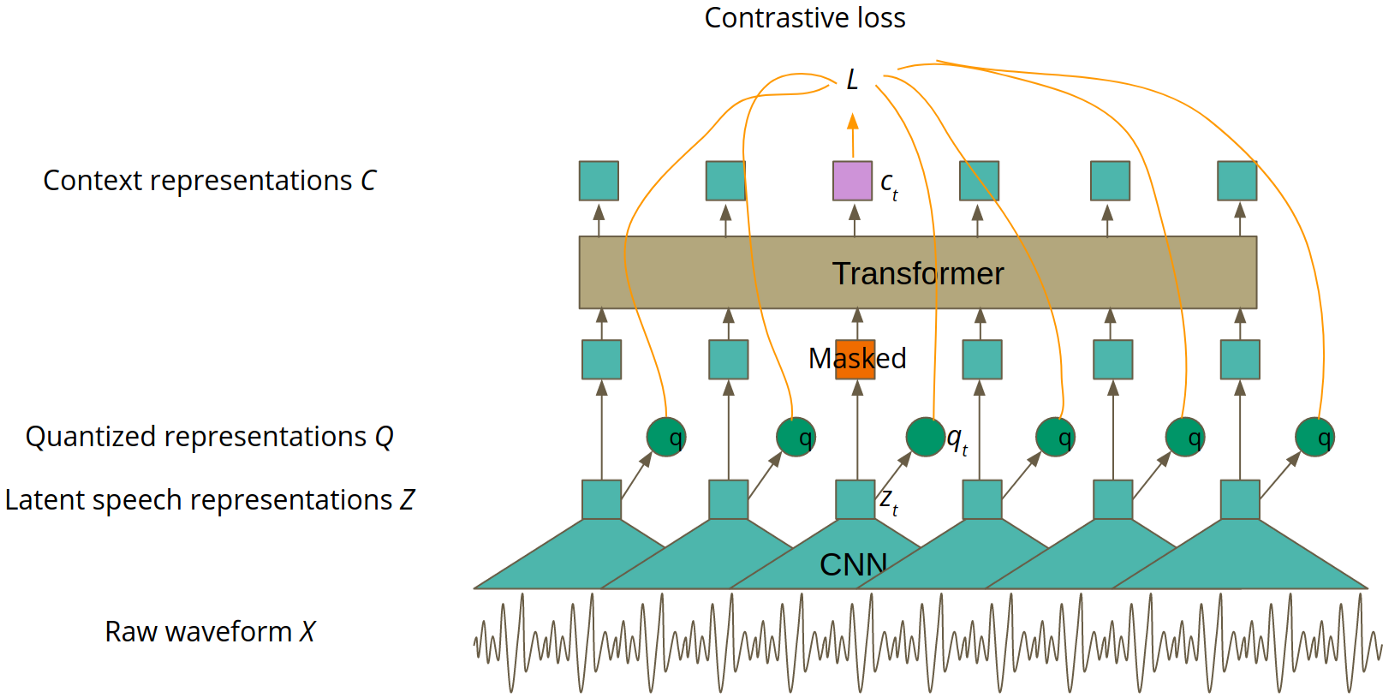

* Using ``manual_seed(0)`` to control sources of randomness that can cause multiple executions of your application to behave differently. And also so that multiple calls to those operations, given the same inputs, will produce the same result.

* A ``torch.device`` is an object representing the device on which a ``torch.Tensor`` is or will be allocated.

* Using ``pipelines`` to import the pretrained model ``WAV2VEC2_ASR_BASE_960H``. In other words, to access the model with pretrained weights, and information/helper functions associated the pretrained weights.

In [8]:
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
SAMPLE_RATE = 16000

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

## ***SAMPLE & NORMALIZATION***
---

***Normalization***

First of all, why do we need normalization feature scaling? - Having features on a similar scale can help the gradient descent converge more quickly towards the minima. We are using normalization for the output features of the Wav2Vec2 pretrained model.


***Definition***

Let $max$ be the greatest value and $min$ be the lowest value from a set of features $F$.

Each feature value $1\leq i\leq|F|$ is bounded between $[-1, 1]$ using the following formula:

$$ F[i] = \frac{2\cdot(F[i]-max)}{max-min}  + 1$$


In [9]:
def normalize_features(features):
    for i in range(len(features[0])):
        mlist = features[0][i]
        features[0][i] = 2 * (mlist - np.max(mlist)) / (np.max(mlist) - np.min(mlist)) + 1

***Resample Padding Method***

Each audio file we used in the project is approximately 2 to 3 seconds long.
Since the model architecture works with fixed input size, we decided that each recording would contain exactly 48,000 samples (3 seconds long, 16k samples in a second). Since there are recordings shorter than 3 seconds, we had to fill in the missing samples by selecting random samples from the recording. This method fairly preserves the imagery of the voice.

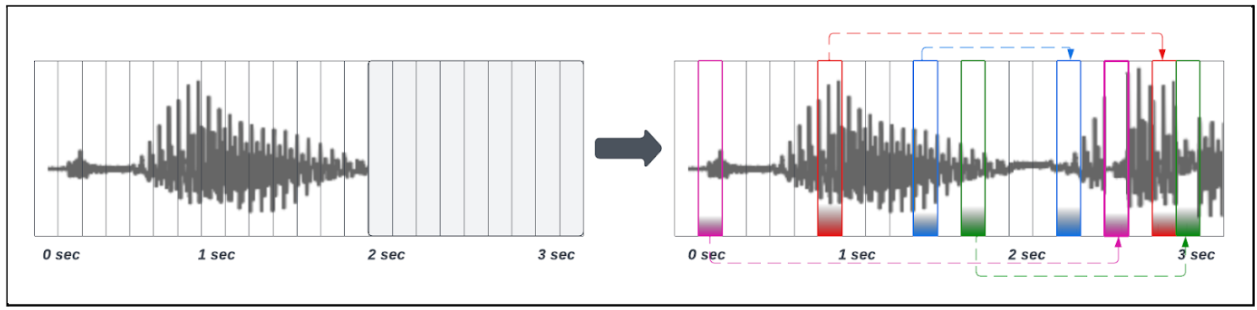


* ``torchaudio`` loads each audio file (path) with 48,000 samples (16,000 * 3).

* We use ``detach()`` because we don't need a tensor to be traced for the gradient computation, we detach the tensor from the current computational graph.

* Using ``numpy()`` to enable actions such as padding new values.


About the resample padding method:

1. Creating ``signal`` - a numpy list of 48,000 zero values.
2. Loading the audio file using ``torch.load()`` - it returns ``waveform`` which is a list of samples.
3. If the audio length is between 2~3 seconds then:
  *   Fill all the samples to the ``signal`` list.
  *   If the audio length is less than 3 seconds (If there is more to fill) then use the ``resample_padding()`` method:
    * We calculate the ``rest`` which is the padding length.
    * We need to choose random values from the audio file and put it in the empty sampled cells. We don't want to choose zero values, so ``filled_list`` list contains non-zero values only to be chosen. 
    * Choose randomly k values from the ``filled_list`` using the ``random.choices()`` method.



In [12]:
def resample_padding(signal, sampling_rate):
    rest = 48000 - sampling_rate # get the number of values to pad
    filled_list = signal[:sampling_rate] # we don't want to choose zero values, so this list contains non-zero values only.
    signal[sampling_rate:] = random.choices(filled_list, k=rest) # choose randomly k values from the filled_list
  
def load_audio(path): 
    signal = np.zeros((int(SAMPLE_RATE*3 ,)))
  
    waveform, sampling_rate = torchaudio.load(filepath=path, num_frames= SAMPLE_RATE * 3)
    waveform = waveform.detach().cpu().numpy()[0]
    waveform_length = len(waveform)

    if waveform_length >= 32000 and waveform_length <= 48000: # if the audio length is between 2 to 3 seconds:
        signal[:waveform_length] = waveform # fill all samples 

        if sampling_rate < 48000: # if there is more to fill (less than 3 seconds):
            resample_padding(signal, sampling_rate)
          
        signal_final = np.array([np.array(signal)]) # bring it back to list of lists form before convert back to tensor.
        signal_final = torch.from_numpy(signal_final).to(device) # convert back to tensor from numpy
        signal_final = signal_final.type(torch.cuda.FloatTensor).to(device) # Tensor containing elements of a single data type (FloatTensor).

        return signal_final

    return -1

# **SAMPLE DATA**
---
Each sample shape is (1, 149, 32)

For each audio file (file_path), we use ``load_audio(file_path)`` which returns a ``torch.Tensor`` containing this audio samples. 

If ``tor`` is successful (is a ``torch.Tensor`` type) then we'll use the pretrained model (Wav2Vec) that provides method to perform the feature extraction and classification in one step so it will return the features (``emission``).

We then normalize the features using ``normalize_features()`` method.

In [ ]:
signals = []

total_data = len(data)
with torch.inference_mode():
    for i, file_path in enumerate(data.Path):
        tor = load_audio(file_path)

        if isinstance(tor, torch.Tensor):
            emission, _ = model(tor)
            features = emission.detach().cpu().numpy()
            normalize_features(features)
            row = (file_path, features, data.iloc[i]['Emotion'])
            signals.append(row)

        percent = (len(signals) / total_data) * 100
        print("\r Processed {}/{} files. ({}%) ".format(len(signals), total_data, round(percent, 1)), end='')


 Processed 4239/4240 files. (100.0%) 

# **SAVE DATA**

---



In [ ]:
counter = [0, 0, 0]

for tup in signals:
  counter[tup[2]] += 1

print(counter)

[1184, 688, 2367]


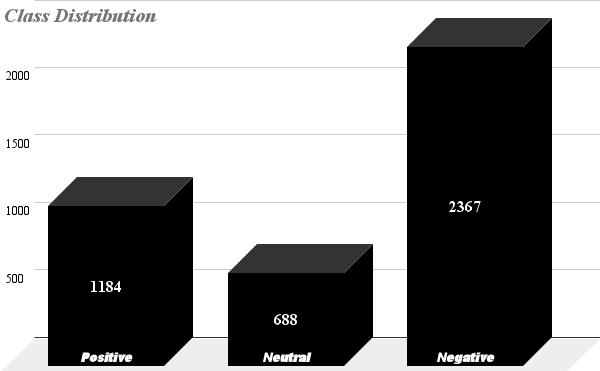

In [ ]:
file_pth = open('/content/dataset444.pth', 'wb')
pickle.dump(signals, file_pth)